In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff7 as ds
from copy import copy as dup
from scipy.integrate import solve_ivp #odeint is deprecated

#for 3d plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

import numba as nb

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
%matplotlib widget

(500, 500)
[-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936
  -9.7995992   -9.75951904  -9.71943888  -9.67935872  -9.63927856]
[-20. -20. -20. -20. -20. -20. -20. -20. -20. -20.]
[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
[-20.         -19.91983968 -19.83967936 -19.75951904 -19.67935872
 -19.5991984  -19.51903808 -19.43887776 -19.35871743 -19.27855711]


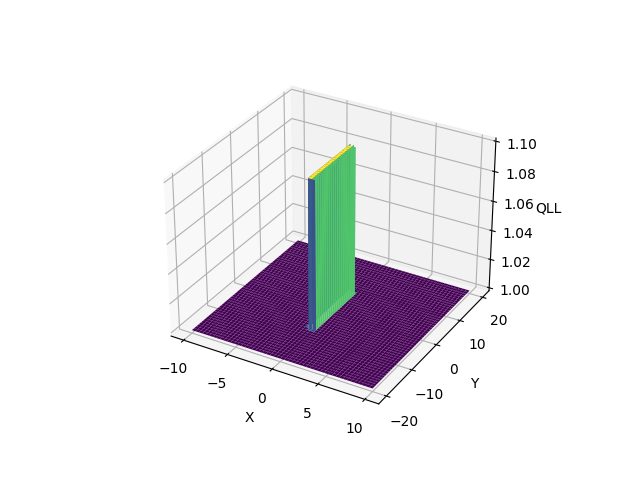

In [3]:
nx = 500
ny = 500

xmax=10
ymax=20
deltaX= 2*xmax/nx


xmid = int(nx/2)
ymid = int(ny/2)

mesh = np.meshgrid(np.linspace(-xmax,xmax,nx),np.linspace(-ymax,ymax,ny))
X = mesh[0].T
Y = mesh[1].T
print(np.shape(X))
print(X[0:10,0])
print(Y[0:10,0])

print(X[0,0:10])
print(Y[0,0:10])

#Fliq = np.ones(np.shape(X)) - 0.001*(X**2 + Y**2) 
Fliq = np.ones(np.shape(X)) 
Fliq[xmid-10:xmid+10,ymid-100:ymid+100] = 1.1

""" plt.figure()

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,X,cmap='viridis')
#ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('X')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Y,cmap='viridis')
#ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Y')
plt.show() """

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

In [28]:
#calculate diffusion differential equation DIY
# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

counter = 10000

dt = 100.0 # microseconds
tmax = counter*dt

Fliq_next = np.copy(Fliq)


for i in range(counter):
    Fliq_next = Fliq_next + np.reshape( ds.diffuse_2d(0.0,np.reshape(Fliq_next,np.prod(np.shape(Fliq))),D,np.shape(Fliq))*dt,np.shape(Fliq))

In [29]:
#try solving with odeint instead #NOTE: not wokring right 

ylast = dup(Fliq)

shape = np.shape(Fliq)
shape = (nx,ny)

# Time steps
t0 = 0.0
tinterval = [t0, tmax]

# Call the ODE solver
layer = 0

# Integrate up to next time step
ode_solution_dict = solve_ivp(ds.diffuse_2d, tinterval, np.reshape(ylast,nx*ny), args=(D,shape))

In [40]:
#inspect solution
print(ode_solution_dict.keys())
Fliq_sol = ode_solution_dict['y']
print(np.shape(Fliq_sol))

Fliq_sol_repacked = np.array(list(map((lambda x: np.reshape(x,shape)),Fliq_sol.T)))
print(np.shape(Fliq_sol_repacked))

print(np.shape(ode_solution_dict['t']))

dict_keys(['t', 'y', 'sol', 't_events', 'y_events', 'nfev', 'njev', 'nlu', 'status', 'message', 'success'])
(250000, 486)
(486, 500, 500)
(486,)


In [31]:
Fliq_next = np.reshape(Fliq_sol_repacked[-1],(nx,ny)) #last element of 'y' is the final state

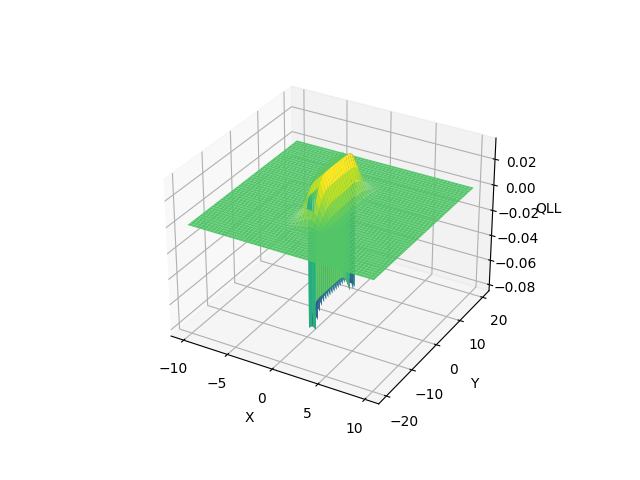

In [32]:
#plot the original minus the calculated diffusive effects
plt.figure()
ax = plt.axes(projection='3d')


#ax.plot_surface(X,Y,Fliq_next,cmap='viridis')
ax.plot_surface(X,Y,Fliq_next-Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

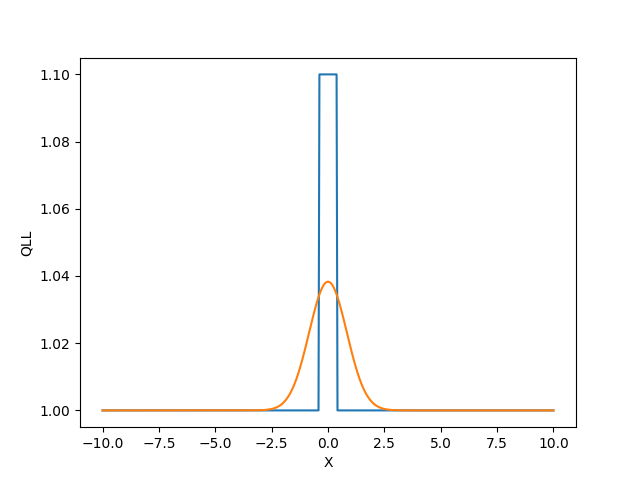

20.080160320641284
20.080160271659317


In [33]:
#slice through the middle of the liquid before diffusion in X

# print(X[:,int(ny/2)])

plt.figure()
ax = plt.axes()
ax.plot(X[:,int(ny/2)],Fliq[:,int(ny/2)])
ax.plot(X[:,int(ny/2)],Fliq_next[:,int(ny/2)])
ax.set_xlabel('X')
ax.set_ylabel('QLL')
plt.show()

print(np.trapz(Fliq[:,int(ny/2)],X[:,int(ny/2)],))
print(np.trapz(Fliq_next[:,int(ny/2)],X[:,int(ny/2)],))


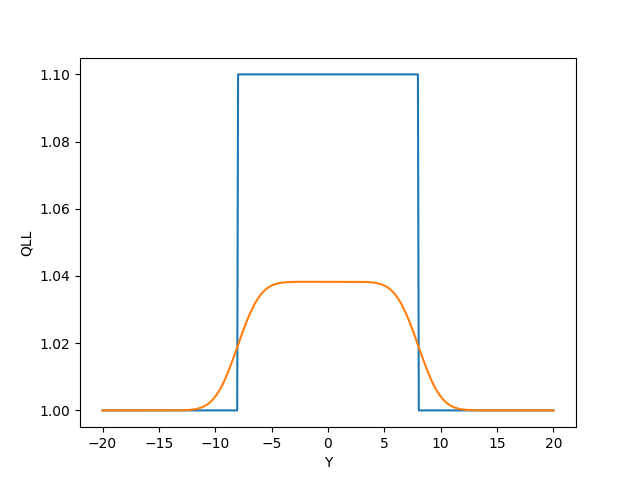

41.60320641282565
40.61395180403259


In [34]:
#slice through the middle of the liquid before diffusion in Y


plt.figure()
ax = plt.axes()
ax.plot(Y[xmid,:],Fliq[xmid,:])
ax.plot(Y[xmid,:],Fliq_next[xmid,:])
ax.set_xlabel('Y')
ax.set_ylabel('QLL')
plt.show()


print(np.trapz(Fliq[xmid,:],Y[xmid,:]))
print(np.trapz(Fliq_next[xmid,:],Y[xmid,:]))


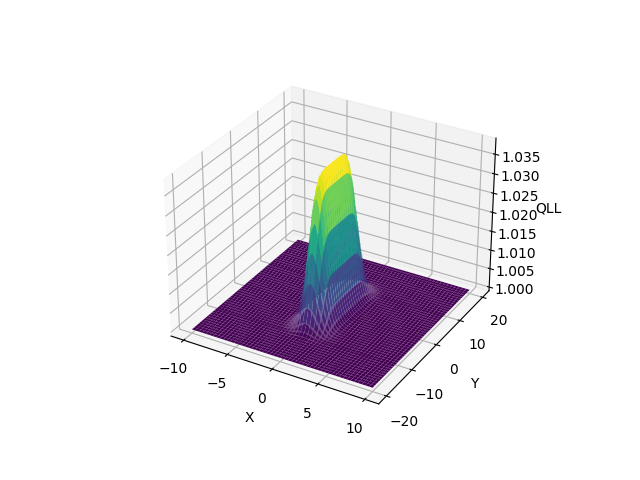

In [35]:
#plot the results
plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X,Y,Fliq_next,cmap='viridis')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

In [ ]:
from matplotlib import animation
from IPython.display import HTML
from datetime import date

In [ ]:
#File management parameters
#Qualifier tag for file names #should include what makes this figure unique
tag = "" ### NOTE: if you do not change the tag between runs on the same day you will overwrite the previous run: try to use a descriptive tag
todays_date = date.today().strftime("%d-%m-%Y")

#File writer for saving animations as gifs
writergif = animation.PillowWriter(fps=480) 

#optional for saving as mp4, (or anim or mpg) but requires ffmpeg

writervideo = animation.FFMpegWriter(fps=60) #make sure files end in .mp4 oetc.

In [ ]:
# These are run control parameters
""" Fliq is the QLL (shape: nx)
    Ntot is the the combined values of the ice layers (Nice), combined with the QLL layer (Nliq or Fliq or NQLL variously referred to as)
        Ntot is shaped (2, nx)
"""


noisy_init = True
noise_std_dev = 0.01

# Flag for explicit updating Fliq(Ntot) every step 
updatingFliq = True
# Set up a maximum number of iterations or layers
uselayers = True

if uselayers:
    layermax_0D = 5
    layermax_1D = 1000
else:
    countermax_0D = 100
    countermax_1D = 15000

In [ ]:
# animation of facet depth over time

Fliqanim = Fliq_sol_repacked
tanim = ode_solution_dict['t']

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(X-xmid,Fliqanim[n])
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

#plt.close()

anim.save(todays_date+"_1D_"+tag+"_"+str(layermax_1D)+"layers.gif", writer=writergif)

HTML(anim.to_jshtml())